In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import diffrax
import matplotlib.pyplot as plt

# Ordinary Differential Equations with diffrax

Diffrax is an awesome package to deal with ordinary (and stochastic, out of scope here) differential equations (ODEs). It is fully compatible with the ``jax`` ecosystem.

## Uncontrolled ODEs

Let us first explore uncontrolled ODEs, i.e. differential equations in the form:
\begin{equation*}
\dot x = f(x)
\end{equation*}

For the sake of concreteness, we work with the Lotka-Volterra ODE in the following:
\begin{align*}
\dot x_1  &= \alpha x - \beta x_1 x_2\\
\dot x_2  &= -\gamma x_2 + \delta x_1 x_2,
\end{align*}

Combining the power of ``jax`` and ``diffrax``, we can simulate ODEs in parallel over arbitrary irregular domains!

In [2]:
# data
nx = 2 # number of state variables of the Lotka-Volterra system
dataset_size = 2_000  # number of sequences in the dataset
seq_len = 40  # length of each sequence (number of time steps, sampling time is irregular)

In [3]:
seed = 1234
key = jr.PRNGKey(seed)
xkey, tkey1, tkey2= jr.split(key, 3)

In [4]:
# generate 40 irregularly-spaced time series from the Lotka-Volterra model

x0 = 8 * jr.uniform(xkey, (dataset_size, 2)) + 6

t0 = 0
t1 = 140 + jr.uniform(tkey1, (dataset_size,))
ts_sol = jr.uniform(tkey2, (dataset_size, seq_len)) * (t1[:, None] - t0) + t0
ts_sol = jnp.sort(ts_sol)
dt0 = 0.1
args = (0.1, 0.02, 0.4, 0.02)


def vector_field(t, y, args):
    prey, predator = y
    α, β, γ, δ = args
    d_prey = α * prey - β * prey * predator
    d_predator = -γ * predator + δ * prey * predator
    d_x = jnp.array([d_prey, d_predator])
    return d_x


def solve(ts, x0):
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(vector_field),
        diffrax.Tsit5(),
        ts[0],
        ts[-1],
        dt0,
        x0,
        saveat=diffrax.SaveAt(ts=ts),
        args=args,
    )
    return sol.ys


x_sol = jax.vmap(solve)(ts_sol, x0)

ts_sol.shape, x_sol.shape

((2000, 40), (2000, 40, 2))

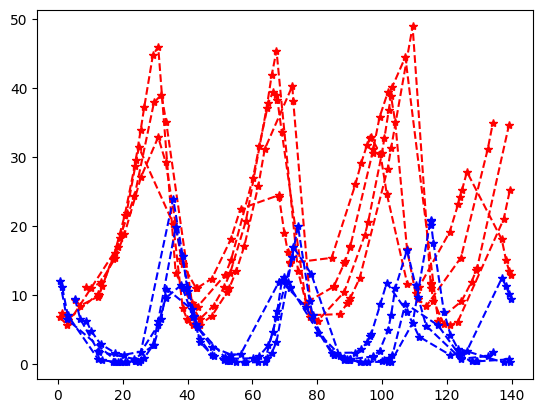

In [5]:
# plot some data
plt.figure()
plt.plot(ts_sol[:4, :].T, x_sol[:4, :, 0].T, "r--*")
plt.plot(ts_sol[:4, :].T, x_sol[:4, :, 1].T, "b--*");

## Controlled ODEs

We consider general-form controlled ODEs defined by:

\begin{equation*}
\dot x(t) = f(x(t), u(t)).
\end{equation*}

For the sake of illustration, we use the first-order linear ODE:
\begin{equation*}
\dot x(t) = a x(t) + bu(t)
\end{equation*}

The input signal $u(t)$ makes things a little bit trickier since, in general, it has to be known at all time instants. If the numerical value of the input is only known on a grid, then $u(t)$ has to be approximated by interpolation according to some assumption such as zero-order hold (ZOH) or linear interpolation. ZOH is common in Control Theory, but it is not provided by default in diffrax. For this reason, we provide an implementation in [interpolation.py](interpolation.py). I tried to follow the software interface of the other interpolators in ``diffrax``, you may come up with a simpler solution.


In the following example, we evaluate the ODE solution over 1000 time instants regularly sampled over a grid. The input $u(t)$ is known over $10$ time points irregularly sampled across the time domain and assumed constant (with ZOH interpolation) within these points.

In [6]:
seed = 1234
key = jr.key(seed)
x0key, tkey, ukey = jr.split(key, 3) # initial state, input, system

In [7]:
# data
nx = 1 # number of states
nu = 1 # number of inputs
seq_len = 1_000 # length of the sequence where we want to evaluate the solution
seq_len_u = 10

In [8]:
def f_xu(x, u, args):
    """ Toy system: first-order dynamics"""
    a = -0.1
    b = 1.0
    return a*x + b*u

In [9]:
dt = 1e-1
ts_sol = jnp.arange(seq_len) * dt
x0 = jr.uniform(x0key, (nx,))
u = jr.uniform(ukey, seq_len_u, minval=-1, maxval=1)
ts_u = jnp.sort(jr.uniform(tkey, seq_len_u, minval=ts_sol[0], maxval=ts_sol[-1]))

In [10]:
from interpolation import ZOHInterpolation
from diffrax import LinearInterpolation
Interpolation = ZOHInterpolation

In [11]:
u_fun = Interpolation(ts=ts_u, ys=u)
def vector_field(t, y, args):
    x = y # state rename...
    ut = u_fun.evaluate(t)
    dx = f_xu(x, ut, args)
    return dx

sol = diffrax.diffeqsolve(
    terms=diffrax.ODETerm(vector_field),
    solver=diffrax.Tsit5(),
    #solver=diffrax.Dopri5(),
    #solver=diffrax.Euler(),
    t0=ts_sol[0],
    t1=ts_sol[-1],
    dt0=dt,
    y0=x0,
    saveat=diffrax.SaveAt(ts=ts_sol),
    #stepsize_controller = diffrax.ConstantStepSize(),
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6, jump_ts=ts_u),
    args=None,
    max_steps=None
)

x_sol = sol.ys

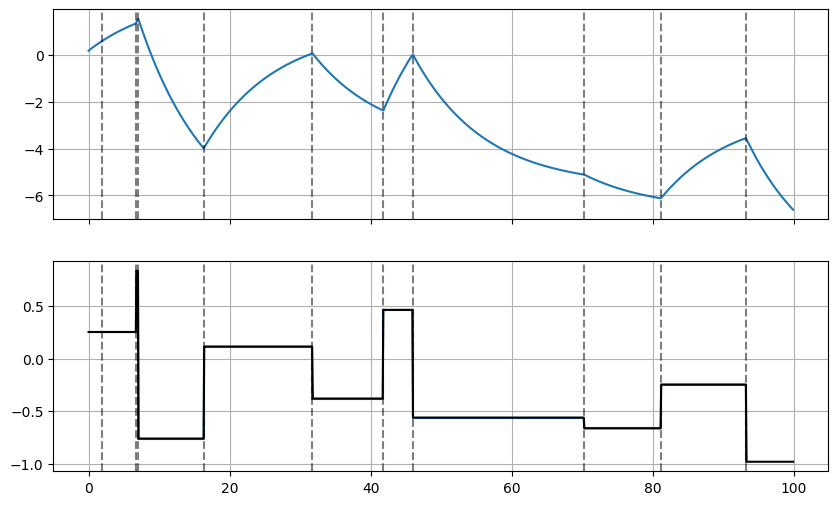

In [12]:
fix, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(ts_sol, x_sol)
ax[0].grid(True)
ax[1].step(ts_u, u, where="post")
ax[1].plot(ts_sol, Interpolation(ts=ts_u, ys=u).evaluate(ts_sol), "k")
ax[1].grid(True)

for t in ts_u:
    ax[0].axvline(t, color="k", linestyle="--", alpha=0.5)
    ax[1].axvline(t, color="k", linestyle="--", alpha=0.5)

With this setup in place, you are close to implementing a truly continuous-time System Identification algorithm!